# Pipeline processing

This notebook demonstrates the continuum imaging and ICAL pipelines.

In [1]:
%matplotlib inline

import os
import sys

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.calibration.solvers import solve_gaintable
from arl.calibration.operations import apply_gaintable, create_gaintable_from_blockvisibility
from arl.data.data_models import Image
from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.base import create_blockvisibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image, copy_image, create_empty_image_like
from arl.visibility.iterators import vis_timeslice_iter
from arl.visibility.coalesce import convert_visibility_to_blockvisibility
from arl.util.testing_support import create_named_configuration, create_low_test_beam, \
    create_low_test_image_from_gleam, simulate_gaintable
from arl.imaging import predict_wstack, invert_wstack, create_image_from_visibility, advise_wide_field
from arl.pipelines.functions import ical

import logging

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All over parameters are determined from this number.

In [2]:
nfreqwin=5
ntimes=11
rmax=300.0
frequency=numpy.linspace(0.8e8,1.2e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

lowcore = create_named_configuration('LOWBD2-CORE', rmax=rmax)

block_vis = create_blockvisibility(lowcore, times, frequency=frequency, channel_bandwidth=channel_bandwidth,
                     weight=1.0, phasecentre=phasecentre,
                     polarisation_frame=PolarisationFrame("stokesI"))

create_blockvisibility: 11 rows, 0.015 GB


In [3]:
wprojection_planes=1
advice=advise_wide_field(block_vis, guard_band_image=4.0, delA=0.02,
                             wprojection_planes=wprojection_planes)

vis_slices = advice['vis_slices']
npixel=advice['npixels2']
cellsize=advice['cellsize']

advise_wide_field: Maximum wavelength 3.747 (meters)


advise_wide_field: Minimum wavelength 2.498 (meters)


advise_wide_field: Maximum baseline 229.0 (wavelengths)


advise_wide_field: Station/antenna diameter 35.0 (meters)


advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)


advise_wide_field: Image field of view 0.428275 (rad) 24.538 (deg)


advise_wide_field: Synthesized beam 0.004366 (rad) 0.250 (deg)


advise_wide_field: Cellsize 0.001455 (rad) 0.083 (deg)


advice_wide_field: Npixels per side = 294


advice_wide_field: Npixels (power of 2, 3) per side = 384


advice_wide_field: W sampling for full image = 0.3 (wavelengths)


advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)


advice_wide_field: Time sampling for full image = 41.7 (s)


advice_wide_field: Time sampling for primary beam = 666.8 (s)


advice_wide_field: Frequency sampling for full image = 57881.5 (Hz)


advice_wide_field: Frequency sampling for primary beam = 926104.3 (Hz)


In [4]:
gleam_model = create_low_test_image_from_gleam(npixel=npixel, frequency=frequency,
    channel_bandwidth=channel_bandwidth, cellsize=cellsize, phasecentre=phasecentre, applybeam=True)

create_low_test_image_from_gleam: 15841 sources inside the image


create_low_test_image_from_gleam: Average flux per channel in image = 6301.070


create_low_test_beam: primary beam is defined at 100.000 MHz


In [5]:
predicted_vis = predict_wstack(block_vis, gleam_model, vis_slices=51)
block_vis=convert_visibility_to_blockvisibility(predicted_vis)
gt = create_gaintable_from_blockvisibility(block_vis)
gt = simulate_gaintable(gt, phase_error=1.0)
blockvis = apply_gaintable(block_vis, gt)

In [6]:
model = create_image_from_visibility(block_vis, npixel=npixel, frequency=[numpy.average(frequency)], nchan=1,
    channel_bandwidth=[numpy.sum(channel_bandwidth)], cellsize=cellsize, phasecentre=phasecentre)

create_image_from_visibility: Parsing parameters to get definition of WCS


create_image_from_visibility: Defining single channel MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 30., -60.)>, starting frequency 100000000.0 Hz, and bandwidth [ 50000000.] Hz


create_image_from_visibility: uvmax = 101.803178 wavelengths


create_image_from_visibility: Critical cellsize = 0.004911 radians, 0.281405 degrees


create_image_from_visibility: Cellsize          = 0.001455 radians, 0.083383 degrees


In [7]:
dirty, sumwt = invert_wstack(predicted_vis, model, vis_slices=vis_slices, dopsf=False)

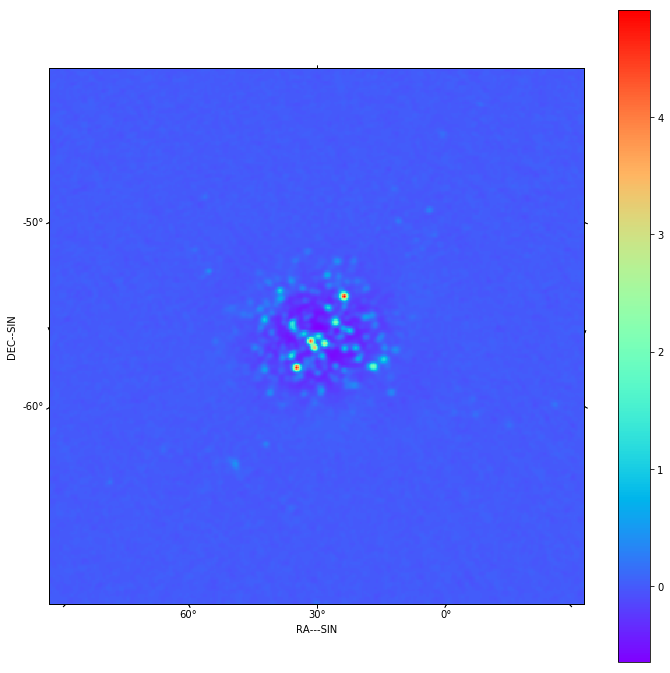

In [8]:
show_image(dirty)
plt.show()

In [9]:
residual_visibility, deconvolved, residual = ical(block_vis=blockvis, model=model, vis_slices=vis_slices, timeslice='auto',
                                       algorithm='hogbom', niter=1000, fractional_threshold=0.1, threshold=0.1,
                                       context='wstack', nmajor=5, gain=0.1, first_selfcal=1, 
                                       global_solution=False)

ical: Performing 5 major cycles


Maximum in residual image is 1.785427


ical: Start of major cycle 0 of 5


deconvolve_cube: Hogbom clean of each polarisation and channel separately


deconvolve_cube: Processing pol 0, channel 0


hogbom: Max abs in dirty image = 1.785427


hogbom: Start of minor cycle


hogbom: This minor cycle will stop at 1000 iterations or peak < 0.178542703316


hogbom: Max abs in dirty Image = 1.785427


hogbom: Minor cycle 0, peak 1.78542703316 at [220, 211]


hogbom: Minor cycle 100, peak 0.384470450752 at [175, 239]


hogbom: Minor cycle 200, peak 0.248329690919 at [222, 210]


hogbom: Stopped at iteration 271, peak 0.177830323029 at [205, 227]


hogbom: End of minor cycle


Maximum in residual image is 0.201890183049


ical: End of major cycle


ical: Start of major cycle 1 of 5


deconvolve_cube: Hogbom clean of each polarisation and channel separately


deconvolve_cube: Processing pol 0, channel 0


hogbom: Max abs in dirty image = 0.201890


hogbom: Start of minor cycle


hogbom: This minor cycle will stop at 1000 iterations or peak < 0.1


hogbom: Max abs in dirty Image = 0.201890


hogbom: Minor cycle 0, peak 0.201890183049 at [211, 200]


hogbom: Minor cycle 100, peak 0.159677891736 at [224, 165]


hogbom: Minor cycle 200, peak 0.13538579793 at [282, 272]


hogbom: Minor cycle 300, peak 0.119048099437 at [201, 206]


hogbom: Stopped at iteration 362, peak 0.0998649988389 at [202, 175]


hogbom: End of minor cycle


ical: Performing selfcalibration


solve_gaintable: Solving for phase only


Quality assessment:
	Origin: qa_gaintable
	Context: Gaintable for selfcal cycle 1
	Data:
		maxabs-amp: 1.0
		minabs-amp: 0.999999999968
		rms-amp: 4.965336941e-12
		medianabs-amp: 0.999999999999
		maxabs-phase: 3.13521287365
		minabs-phase: -3.13115990484
		rms-phase: 1.38385531063
		medianabs-phase: -0.125919832398
		residual: 2.62158742601



In [ ]:
f=show_image(deconvolved, title='Clean image')
print(qa_image(deconvolved, context='Clean image'))
plt.show()

f=show_image(residual, title='Residual clean image')
print(qa_image(residual, context='Residual clean image'))
plt.show()
export_image_to_fits(residual, '%s/imaging-dask_ical_residual.fits' 
                     %(results_dir))